<a href="https://colab.research.google.com/github/SevenYoshis/MovieScriptNLPAnalysis/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stanza
# ! git clone https://github.com/SevenYoshis/MovieScriptNLPAnalysis/ drive/MyDrive/MovieScriptNLPAnalysis

     |████████████████████████████████| 432 kB 12.8 MB/s 
     |████████████████████████████████| 170 kB 61.7 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=d43057f03b01c4990b4b75992a125e50507a21fc8839bfc7093a0c8746442045
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [2]:
import os
import pandas as pd
import re
import stanza
import numpy as np
import plotly.express as px
from tqdm import tqdm
tqdm.pandas()

In [3]:
# ! git clone https://github.com/SevenYoshis/MovieScriptNLPAnalysis/ drive/MyDrive/MovieScriptNLPAnalysis
base_path = 'drive/MyDrive/MovieScriptNLPAnalysis'
spreadsheets_path = 'Movie_spreadsheets'
data_path = os.path.join(base_path, spreadsheets_path)

## Cleaning messy scripts

In [4]:
def split_lines_with_character_tags(df):
    df['line #'] = df.index
    df['line'] = df['line'].str.replace('\n', ' ')
    df['character'] = df['character'].str.replace(r"\(.+\)", '').str.strip()
    df['original character'] = df['character']

    df['line'] = df['line'].str.replace('\(cont\'d\)', '', flags=re.IGNORECASE)
    df = df[df['character'].str.strip().str.len() != 0]

    for character in df['original character'].unique():
        while len(df[df['line'].str.contains(re.escape(character))]) > 0:
            new_rows = df[df['line'].str.contains(character)].copy()
            new_rows.loc[:,'line'] = new_rows['line'].str.split(character).apply(lambda x: x[1])
            df.loc[:,'line'] = df['line'].str.split(character).apply(lambda x: x[0])
            new_rows['character'] = character
            new_rows.loc[:,'line #'] += .001
            df = df.append(new_rows)
            df = df.sort_values(by='line #').reset_index(drop=True)
            df.loc[:, 'line #'] = df.index

    df = df.drop('original character', axis=1)        
    df['character'] = df['character'].str.replace(r'[^A-z]','')

    df = df[df['line'].str.strip().str.len() != 0]
    df = df[df['character'].str.strip().str.len() != 0]
    return df

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

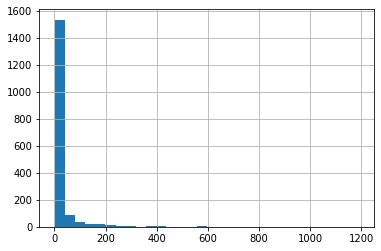

In [6]:
df = pd.DataFrame()
movie_id = 0
for file in sorted(os.listdir(data_path)):
    if file.endswith('.csv'):
        movie_title = file.replace('.csv', '')
        # print(movie_title)
        individual_df = pd.read_csv(os.path.join(data_path, file), index_col=0)
        individual_df['movie_id'] = movie_id
        movie_id += 1
        individual_df['movie_title'] = movie_title
        individual_df = split_lines_with_character_tags(individual_df)
        df = df.append(individual_df)

# Weird problem in the labeling of Black Panther
df = df[~df['character'].isin(['T', 'A', 'N'])]

character_counts = df['character'].value_counts()
character_counts.hist(bins=30)

In [33]:
top_characters = character_counts[character_counts > 100].index
df = df[df['character'].isin(top_characters)]
df.groupby(['movie_title', 'character']).count()

line #  line  ...  relative_line_id  combined_name
movie_title            character                ...                                 
8mm                    EDDIE          70    70  ...                70             70
                       MAX            66    66  ...                66             66
                       WELLES        421   421  ...               421            421
ALongKissGoodnight     CHARLY        188   188  ...               188            188
                       HENESSEY      162   162  ...               162            162
...                                  ...   ...  ...               ...            ...
heat                   NATE           60    60  ...                60             60
                       NEIL          272   272  ...               272            272
rockyhorrorpictureshow EDDIE           7     7  ...                 7              7
                       FRANK         124   124  ...               124            124
                       JANET         100   100  ...               100            100

[134 rows x 7 columns]

In [34]:
stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')

def sentiment_score(text):
    doc = nlp(text)
    scores = []
    for i, sentence in enumerate(doc.sentences):
        scores.append(sentence.sentiment)
    return np.mean(scores)

2021-11-17 02:37:42 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-11-17 02:37:42 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-11-17 02:37:42 INFO: Use device: gpu
2021-11-17 02:37:42 INFO: Loading: tokenize
2021-11-17 02:37:42 INFO: Loading: sentiment
2021-11-17 02:37:43 INFO: Done loading processors!


In [35]:
df['sentiment'] = df['line'].progress_apply(sentiment_score)

100%|██████████| 24757/24757 [05:02<00:00, 81.89it/s]


In [36]:
df['movie_length'] = 0
for movie_id in tqdm(df['movie_id']):
    movie_length = df.loc[df['movie_id'] == movie_id]['line #'].max()
    df.loc[df['movie_id'] == movie_id, 'movie_length'] = movie_length
df['relative_line_id'] = df['line #'] / df['movie_length']


# df['character_mean'] = 0
# df['character_std'] = 0
# for character in df['character'].unique():
#     character_std = df[df['character'] == character]['sentiment'].std()
#     character_mean = df[df['character'] == character]['sentiment'].mean()
#     df.loc[df['character'] == character, 'character_mean'] = character_mean
#     df.loc[df['character'] == character, 'character_std'] = character_std
# df['normalized_sentiment'] = (df['sentiment'] - df['character_mean']) / df['character_std']

In [37]:
df['combined_name'] = df['movie_title'].str.cat(df['character'], sep='_')
df.to_csv('movie_df.csv')

In [60]:
expanded_movie_size = df['movie_length'].max()
sentiment_df = np.ones(shape=(len(df['combined_name'].unique()), expanded_movie_size))
sentiment_df = pd.DataFrame(sentiment_df)
sentiment_df.index = df['combined_name'].unique()

# Arbitrarily mark cells whose sentiment scores did not originate from the movie dataframe.
# True sentiment scores cannot be less than -1
sentiment_df = sentiment_df * -10

for row in df.iterrows():
    sentiment_df.loc[row[1]['combined_name'], np.round(row[1]['relative_line_id'] * (expanded_movie_size - 1))] = row[1]['sentiment']

In [116]:
def expand_row(row):
    std = row[row != -10].std()
    if row[0] == -10:
        first_nonempty_index = row[row != -10].index[0]
        first_nonempty_value = row[row != -10].loc[first_nonempty_index]
        gaussian_noise = np.random.normal(0, std / 5, size=first_nonempty_index)
        # gaussian_noise = 0
        row[:first_nonempty_index] = first_nonempty_value + gaussian_noise
    for i in range(len(row)):
        if row[i] == -10:
            gaussian_noise = np.random.normal(0, std / 5)
            # gaussian_noise = 0
            row[last_index:i+1] = last_val + gaussian_noise
        last_index = i
        last_val = row[i]
    std = row[row != -10].std()
    # print(type(row))
    # print(row.where(row > -10))
    row = (row - row.mean()) / std

    return row
        
        
sentiment_df = sentiment_df.progress_apply(expand_row, axis=1)

100%|██████████| 129/129 [00:02<00:00, 47.49it/s]


In [117]:
rolling_sentiment_devisor = 1

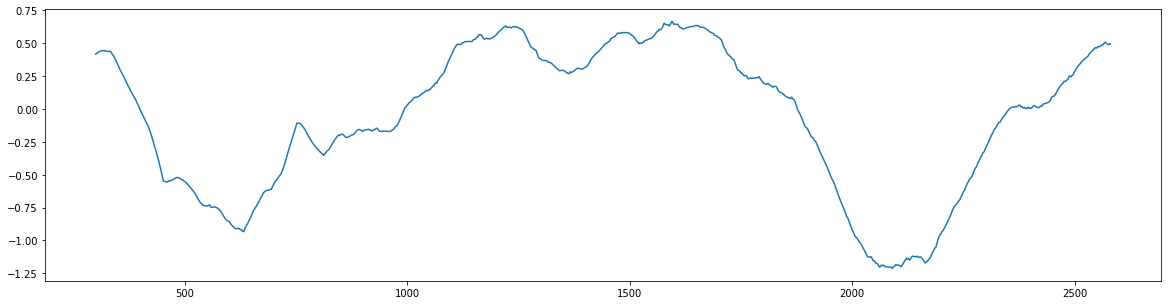

In [118]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(sentiment_df.loc['TheSocialNetwork_EDUARDO'].rolling(300).mean())

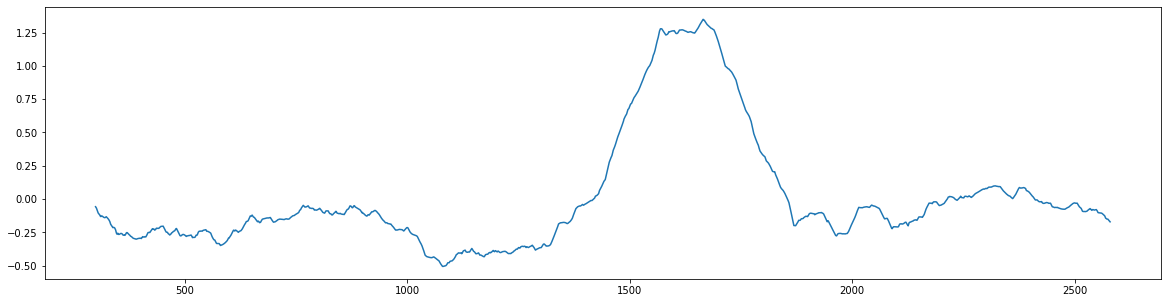

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(sentiment_df.loc['TheSocialNetwork_MARK'].rolling(300).mean())

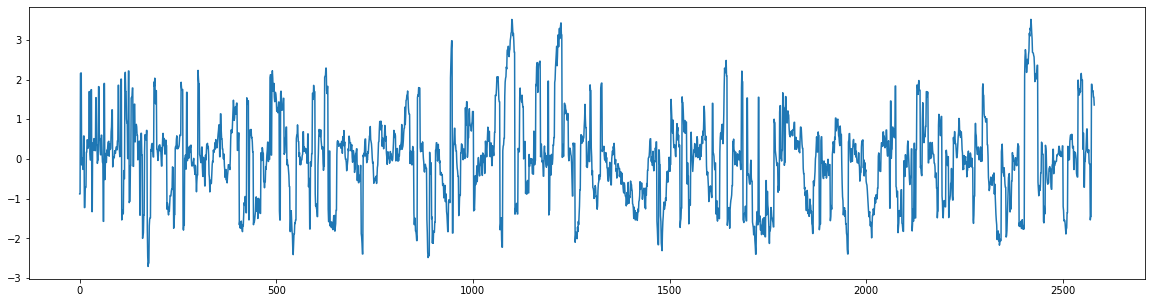

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(sentiment_df.loc['Coco_MIGUEL'])

In [121]:
from sklearn.decomposition import PCA
pca = PCA()

In [122]:
sentiment_df = sentiment_df.dropna()

In [123]:
pca_df = pd.DataFrame(pca.fit_transform(sentiment_df))
pca_df.index = sentiment_df.index

In [139]:
sentiment_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580
8mm_WELLES,-0.259551,-0.387475,0.024033,-0.057996,0.221957,0.222325,0.328127,0.452277,0.452277,0.521254,0.402814,0.192870,-0.111056,-0.065809,-0.065809,-1.546006,-1.642578,-1.714439,-1.891315,-1.760882,-1.717264,-1.634743,-1.401583,-1.345851,-0.985001,-0.845570,-0.845570,0.464583,0.097249,0.116922,0.153573,0.153573,-0.693782,-0.654604,-0.537030,-0.550493,-0.623373,-0.623373,0.537311,0.564112,...,0.158954,0.492546,0.613648,0.613648,-0.258669,-0.127309,-0.127309,0.349674,0.349674,0.333852,0.088651,0.088651,0.415182,0.623093,0.623093,-0.321526,-0.431777,-0.265961,-0.230931,-0.606259,-0.084666,-0.321052,-0.448614,-0.448614,-1.656812,-1.721994,-1.721994,-1.465229,-1.259901,-1.217447,-1.360294,-1.316345,-1.316345,0.306624,0.177819,0.177819,0.247678,0.238105,0.238105,0.361553
8mm_MAX,0.757685,0.619071,0.951763,0.600755,0.611047,0.822601,0.652277,0.916115,0.998100,0.650133,0.729771,0.789969,0.931848,0.777830,0.854865,0.687769,0.753885,0.858353,0.850058,0.831166,0.878984,0.851321,0.690806,0.848287,0.793118,0.725594,0.800239,0.630699,0.696834,0.933926,0.746189,0.778030,0.773780,0.766303,0.803989,0.762540,0.714344,0.736309,0.772363,0.706549,...,-1.984181,-1.833794,-1.947739,-2.022009,-2.035322,-2.044185,-2.100964,-2.126315,-2.200595,-2.230484,-2.233220,-2.074237,-1.922347,-2.049236,-2.014008,-2.161396,-2.111269,-2.215385,-2.338105,-2.264750,-2.218156,-2.234787,-2.354733,-2.456556,-2.245173,-2.246473,-2.286922,-2.263303,-2.228244,-2.149967,-2.124026,-2.147618,-2.150762,-2.030710,-1.991705,-2.148521,-2.264309,-2.394287,-2.223748,-2.223748
8mm_EDDIE,0.335869,0.374599,0.338403,0.285649,0.194898,0.449951,0.263911,0.171706,0.338486,0.479730,0.269856,0.194427,0.328749,0.341088,0.284855,0.284013,0.287408,-0.033637,0.410740,0.212604,0.420163,0.359282,0.259806,0.286302,0.153585,0.221590,0.382928,0.464047,0.288387,0.302842,0.299445,0.274910,0.269191,0.372786,0.321182,0.368641,0.242085,0.193306,0.229991,0.276118,...,-0.488552,-0.510579,-0.613557,-0.524226,-0.516869,-0.585051,-0.762185,-0.539416,-0.533663,-0.640935,-0.673235,-0.740539,-0.743570,-0.581428,-0.425342,-0.453779,-0.343984,-0.291340,-0.371037,-0.318676,-0.348699,-0.306826,-0.411813,-0.476761,-0.493698,-0.325870,-0.397816,-0.440929,-0.473473,-0.723341,-0.668871,-0.774712,-0.922037,-0.757624,-0.823540,-0.815950,-0.810241,-0.699685,-0.742102,-0.742102
ALongKissGoodnight_SAMANTHA,0.860816,1.044204,0.879940,0.956627,0.834268,0.917090,0.912405,0.979510,0.846750,0.829352,1.068762,0.878931,0.931849,0.827628,0.835847,1.042452,0.927621,0.806127,0.943434,0.758178,1.008094,0.864862,0.915777,0.901650,0.975172,0.859252,0.859252,0.712660,0.621931,0.674257,0.666457,0.786473,0.786473,0.153499,0.311141,0.397135,0.274127,0.243510,0.243510,0.912786,...,-2.824859,-2.783776,-2.734418,-2.597943,-2.623555,-2.601247,-2.540249,-2.460139,-2.488230,-2.388283,-2.384946,-2.197971,-2.136772,-2.020111,-2.002024,-1.887500,-1.896403,-1.914835,-1.832778,-1.759225,-1.725998,-1.672509,-1.778458,-1.684987,-1.639368,-1.630180,-1.546943,-1.393956,-1.333029,-1.192824,-1.228399,-1.381355,-1.267021,-1.241209,-1.006032,-1.092282,-1.060366,-1.085662,-1.154751,-1.154751
ALongKissGoodnight_HENESSEY,0.384506,0.193810,0.104812,0.354375,0.195704,0.123773,0.103463,0.305335,0.100677,0.306246,0.282779,0.162629,0.137827,0.511207,-0.013149,0.341945,0.229018,0.274741,0.016066,0.316760,0.203050,0.232539,0.220997,0.219784,0.280905,0.314184,0.041431,0.081121,0.154282,0.365833,0.126574,0.317313,0.107286,-0.059362,-0.138205,-0.078931,0.274825,0.087740,0.169610,0.135073,...,1.804557,1.719472,1.723967,1.766270,1.772012,1.735197,1.471524,1.390602,1.476087,1.423260,1.427789,1.595471,1.550765,1.383271,1.339944,1.343448,1.441387,1.388998,1.380442

In [159]:
px.scatter(pca_df.reset_index(), 0, 1,hover_name='index')

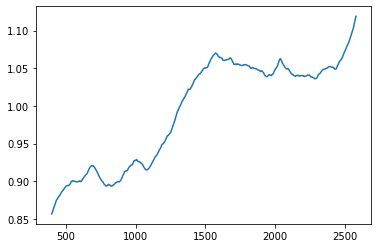

In [138]:
sd_df = sentiment_df.std().rolling(window=400).mean()
plt.plot(sd_df)

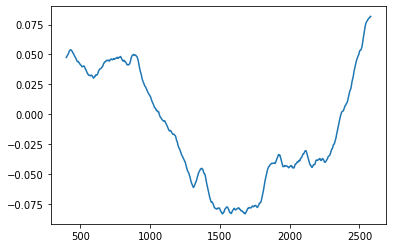

In [137]:
plt.plot(sentiment_df.columns, sentiment_df.mean().rolling(window=400).mean())

In [ ]:
from math import isclose

# STD may not exactly equal 1 since std was calculated character-wise.
# Mean should be zero, except for floating point error
# assert(isclose(sentiment_df['normalized_sentiment'].mean(), 0, abs_tol=1e-10))
# assert(isclose(sentiment_df['normalized_sentiment'].std(), 1, abs_tol=.01))

In [141]:
ron_df = df[df['character'] == 'RONSTALLWORTH']
ron_df = ron_df.rolling(window=len(ron_df)//5).mean()
px.line(ron_df, x='relative_line_id', y='sentiment')

In [156]:
df.groupby(['character','movie_title']).count()

line #  ...  combined_name
character  movie_title                                        ...               
ALISON     KnockedUp                                     452  ...            452
ANAKIN     AttackOfTheClones                             192  ...            192
ANDY       DevilWearsPrada                               308  ...            308
ARIADNE    Inception                                     177  ...            177
ARTHUR     Arthur                                        435  ...            435
...                                                      ...  ...            ...
WELLES     8mm                                           421  ...            421
WILLIE     FabulousBakerBoys                               4  ...              4
           IndianaJonesAndTheTempleOfDoom                217  ...            217
WILLTURNER Pirates-of-the-Caribbean-Dead-Man's-Chest     133  ...            133
WOODWARD   AllThePresidentsMen                           276  ...            276

[134 rows x 7 columns]

In [157]:
mark_df = df[df['character'] == 'MARK'].sort_values('relative_line_id')
mark_df = mark_df.rolling(window=len(mark_df)//2).mean()
px.line(mark_df, x='relative_line_id', y='sentiment')

In [143]:
eduardo_df = df[df['character'] == 'EDUARDO']
eduardo_df = eduardo_df.rolling(window=len(eduardo_df)//2).mean()
px.line(eduardo_df, x='relative_line_id', y='sentiment')

In [158]:
miguel_df = df[df['character'] == 'MIGUEL']
miguel_df = miguel_df.rolling(window=len(miguel_df)//2).mean()
px.line(miguel_df,  x='relative_line_id', y='sentiment')